In [1]:
%pylab inline
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (6,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
import pathlib

In [4]:
DATA_DIR = pathlib.Path("data/")

# Loading the data

In [5]:
DATASET = "FordA"

In [6]:
train = pd.read_table(DATA_DIR.joinpath(DATASET, f"{DATASET}_TRAIN.tsv"), header=None)
test = pd.read_table(DATA_DIR.joinpath(DATASET, f"{DATASET}_TEST.tsv"), header=None)

In [7]:
train.notnull().sum(axis=1).sort_values()

0       501
2393    501
2394    501
2395    501
2396    501
       ... 
1204    501
1205    501
1206    501
1236    501
3600    501
Length: 3601, dtype: int64

In [8]:
test.notnull().sum(axis=1).sort_values()

0       501
883     501
882     501
881     501
880     501
       ... 
437     501
436     501
435     501
433     501
1319    501
Length: 1320, dtype: int64

In [9]:
NUM_SAMPLES = 20
samples = train.sample(NUM_SAMPLES, replace=False)

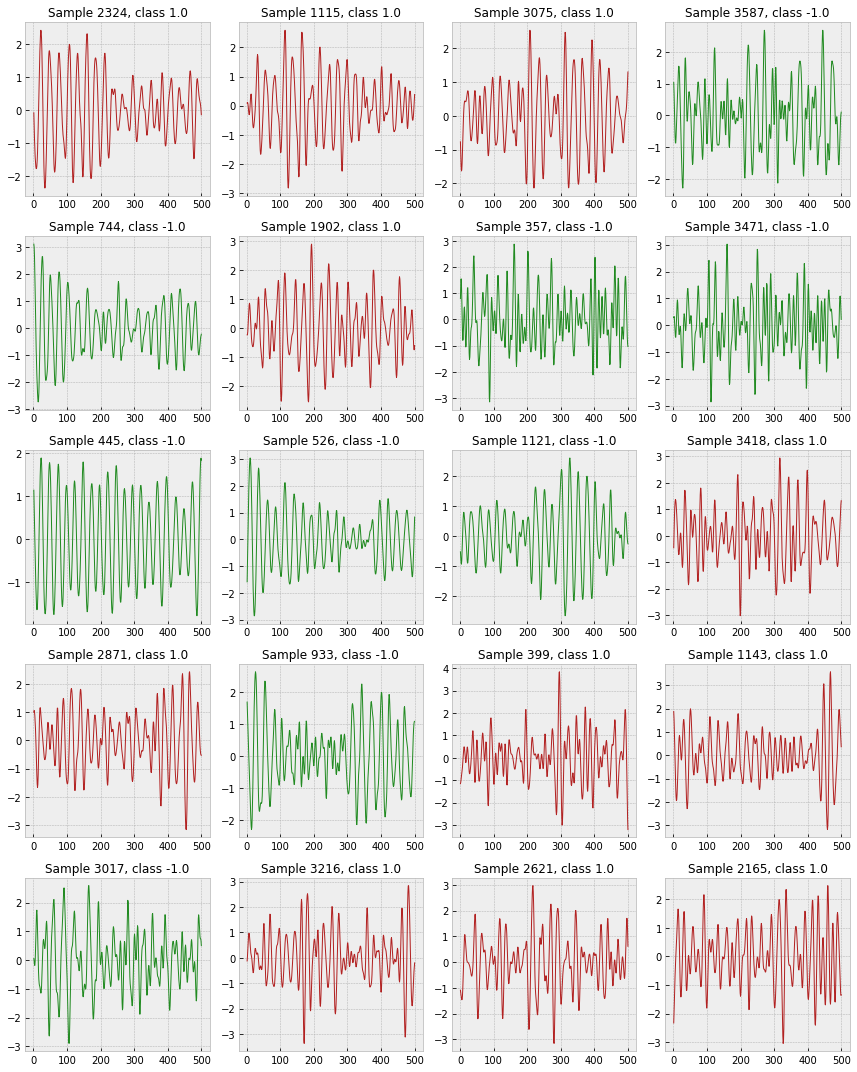

In [10]:
plt.figure(figsize=(12, 15))

for si, (sidx, sample) in enumerate(samples.iterrows()):
    sample_class = sample.iloc[0]
    sample_series = sample.iloc[1:]

    ax = plt.subplot(5, 4, si + 1)
    sample_series.plot(linewidth=1, c="firebrick" if sample_class==1 else "forestgreen", ax=ax)
    plt.title(f"Sample {sidx}, class {sample_class}", fontsize=12)

plt.tight_layout()
plt.show()

In [11]:
train.iloc[:, 0].value_counts()

-1    1846
 1    1755
Name: 0, dtype: int64

In [12]:
test.iloc[:, 0].value_counts()

-1    681
 1    639
Name: 0, dtype: int64

# Spectral composition

In [13]:
from scipy.signal import welch

In [14]:
f, w = welch(samples.iloc[:, 1:].values, nperseg=256, fs=1)

Text(0.5, 1.0, 'Power spectra for different classes')

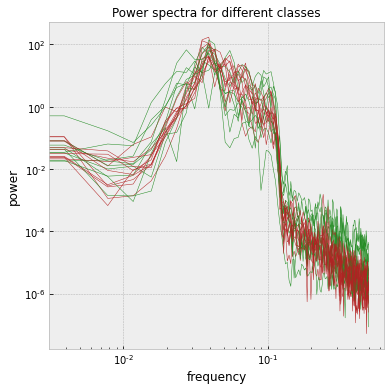

In [15]:
colors = ["firebrick" if c==1 else "forestgreen" for c in samples.iloc[:, 0]]

for i in range(NUM_SAMPLES):
    plt.plot(f, w[i], c=colors[i], linewidth=0.5)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("frequency")
plt.ylabel("power")
plt.title("Power spectra for different classes", fontsize=12)

# Convolutions

In [16]:
# PyTorch imports
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset

# PyTorch Lightning imports
import pytorch_lightning as pl

Convolutional layers have multiple important parameters, which influence the length of the output:
    
$$
L_{out} = \left\lfloor\frac{L_{in} + 2 \times \text{padding} - \text{dilation}
                    \times (\text{kernel\_size} - 1) - 1}{\text{stride}} + 1\right\rfloor
$$

In [17]:
KERNEL_SIZE = 3

conv = nn.Conv1d(1, 8, KERNEL_SIZE)

In this case, output is

$$
L_{out} = \left\lfloor\frac{L_{in} - 1
                    \times (3 - 1) - 1}{1} + 1\right\rfloor = L_{in} - 2
$$

In [18]:
conv_sample = samples.iloc[0, 1:].values.reshape(1, 1, -1)

In [19]:
out = conv(torch.Tensor(conv_sample))

In [20]:
out.shape, conv_sample.shape

(torch.Size([1, 8, 498]), (1, 1, 500))

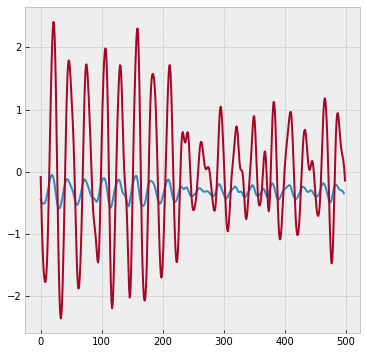

In [21]:
plt.plot(out.detach().numpy()[0, 0])
plt.plot(conv_sample[0][0])

For convolution with the padding of `1`:

$$
L_{out} = \left\lfloor\frac{L_{in} + 2 \times 1 - 1
                    \times (3 - 1) - 1}{1} + 1\right\rfloor = L_{in}
$$

In [22]:
conv_pad = nn.Conv1d(1, 8, KERNEL_SIZE, padding=1)

In [23]:
out_pad = conv_pad(torch.Tensor(conv_sample))

In [24]:
out_pad.shape, conv_sample.shape

(torch.Size([1, 8, 500]), (1, 1, 500))

# Inception block

## Convolutions

In [25]:
LONG_KS = 20
SHORT_KS = 10
NUM_KERNELS = 8
PADDING = "replicate"

conv_long = nn.Conv1d(1, NUM_KERNELS, LONG_KS, padding=(LONG_KS - 1) // 2, padding_mode=PADDING)
conv_short = nn.Conv1d(1, NUM_KERNELS, SHORT_KS, padding=(SHORT_KS - 1) // 2, padding_mode=PADDING)

In [26]:
out_long = conv_long(torch.Tensor(conv_sample))
out_short = conv_short(torch.Tensor(conv_sample))

In [27]:
out_long.size(), out_short.size()

(torch.Size([1, 8, 499]), torch.Size([1, 8, 499]))

In [28]:
torch.cat([out_long, out_short], dim=1).size()

torch.Size([1, 16, 499])

## Pooling

In [29]:
max_pool = nn.MaxPool1d(10, stride=1, padding=4)
out_maxpool = max_pool(torch.Tensor(conv_sample))
out_maxpool.size()

torch.Size([1, 1, 499])

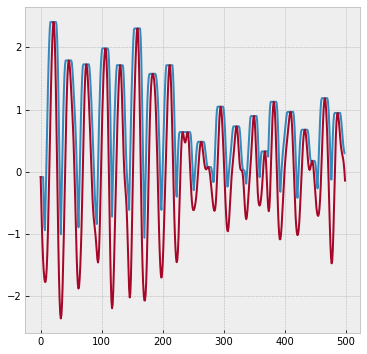

In [30]:
plt.plot(out_maxpool.detach().numpy()[0, 0])
plt.plot(conv_sample[0][0])

## InceptionBlock implementation

In [31]:
class InceptionBlock(pl.LightningModule):
    def __init__(self, in_channels, bottleneck_size, base_ks, num_kernels, activation=False):
        super().__init__()

        self.in_channels = in_channels
        self.bottleneck_size = bottleneck_size
        self.base_ks = base_ks
        self.num_kernels = num_kernels
        self.activation = activation
        
        self.bottleneck = (nn.Conv1d(self.in_channels, self.bottleneck_size, 1)
                           if self.in_channels!=1
                           else nn.Identity())

        self.shortest_conv = nn.Conv1d(in_channels=self.bottleneck_size,
                                       out_channels=self.num_kernels,
                                       kernel_size=self.base_ks,
                                       padding=(self.base_ks - 1) // 2)
        self.short_conv = nn.Conv1d(in_channels=self.bottleneck_size,
                                    out_channels=self.num_kernels,
                                    kernel_size=self.base_ks * 2,
                                    padding=(self.base_ks * 2 - 1) // 2)
        self.long_conv = nn.Conv1d(in_channels=self.bottleneck_size,
                                   out_channels=self.num_kernels,
                                   kernel_size=self.base_ks * 4,
                                   padding=(self.base_ks * 4 - 1) // 2)

        self.max_pool = nn.MaxPool1d(kernel_size=self.base_ks,
                                     stride=1,
                                     padding=(self.base_ks - 1) // 2)

        self.out_channels = self.num_kernels * 3 + self.in_channels
        self.activation_module = nn.ReLU() if self.activation else nn.Identity()
    
    def forward(self, x):
        x_b = self.bottleneck(x)
        
        x_shortest = self.shortest_conv(x_b)
        x_short = self.short_conv(x_b)
        x_long = self.long_conv(x_b)
        x_pool = self.max_pool(x)

        if self.activation:
            x_shortest = self.activation_module(x_shortest)
            x_short = self.activation_module(x_short)
            x_long = self.activation_module(x_long)

        return torch.cat([x_shortest, x_short, x_long, x_pool], dim=1)


In [32]:
inception_block = InceptionBlock(1, 1, 10, 8, activation=True)

In [33]:
inception_block.bottleneck

Identity()

In [34]:
out_inception = inception_block(torch.Tensor(conv_sample))

In [35]:
inception_block.out_channels

25

In [36]:
out_inception.size()

torch.Size([1, 25, 499])

# DalaModule

In [37]:
class CarDataset(Dataset):
    """Dataset which samples the data from hourly electricity data."""

    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        class_label = int(sample.iloc[0]==1)
        values = sample.iloc[1:].values

        return (torch.Tensor(values.reshape(1, -1)),
                torch.Tensor([class_label]))

In [38]:
ds = CarDataset(train)

In [39]:
ds[0]

(tensor([[-7.9717e-01, -6.6439e-01, -3.7301e-01,  4.0815e-02,  5.2694e-01,
           9.8429e-01,  1.3531e+00,  1.5781e+00,  1.6593e+00,  1.6408e+00,
           1.5523e+00,  1.4380e+00,  1.2794e+00,  1.0691e+00,  7.4455e-01,
           2.7761e-01, -3.0072e-01, -9.3733e-01, -1.5201e+00, -1.9516e+00,
          -2.1360e+00, -2.0401e+00, -1.7229e+00, -1.2619e+00, -8.0455e-01,
          -4.6153e-01, -2.7822e-01, -2.5130e-01, -3.0183e-01, -3.1326e-01,
          -2.0446e-01,  6.7002e-02,  4.7161e-01,  9.3265e-01,  1.3531e+00,
           1.6445e+00,  1.7588e+00,  1.6961e+00,  1.4822e+00,  1.1798e+00,
           8.2569e-01,  4.4948e-01,  7.2535e-02, -2.9704e-01, -6.4595e-01,
          -9.7421e-01, -1.2508e+00, -1.4094e+00, -1.4279e+00, -1.3025e+00,
          -1.0627e+00, -7.4922e-01, -4.1727e-01, -1.0746e-01,  1.6880e-01,
           3.9784e-01,  5.7488e-01,  6.8553e-01,  7.1873e-01,  6.7816e-01,
           5.4907e-01,  3.3256e-01,  6.3314e-02, -2.1515e-01, -4.6891e-01,
          -6.5702e-01, -7

In [40]:
class CarDataModule(pl.LightningDataModule):
    """DataModule for electricity data."""

    def __init__(self, train_df, val_df, test_df,
                 batch_size=32, workers=1):

        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.workers = workers

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_ds = CarDataset(self.train_df)
            self.val_ds = CarDataset(self.val_df)

        if stage == "test" or stage is None:
            self.test_ds = CarDataset(self.test_df)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, num_workers=self.workers)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, num_workers=self.workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.workers)

In [41]:
train.shape

(3601, 501)

In [42]:
TRAIN_SIZE = 2500

train_df = train.sample(TRAIN_SIZE, replace=False)
val_df = train.loc[train.index.difference(train_df.index)]

In [43]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
257,1,-0.575583,-0.640863,-0.569658,-0.367164,-0.070533,0.274927,0.611776,0.890904,1.084406,...,-0.804762,-0.482312,-0.089853,0.297524,0.598775,0.753562,0.748514,0.570162,0.254624,-0.141052
1464,-1,-0.888183,-0.968151,-1.030735,-1.079411,-1.128087,-1.166332,-1.166332,-1.107225,-0.985535,...,2.425263,2.282712,1.980225,1.563002,1.104057,0.665973,0.266134,-0.102413,-0.446622,-0.787354
242,1,-0.058958,-0.685459,-1.178088,-1.486079,-1.585168,-1.511224,-1.318736,-1.068687,-0.825384,...,0.380685,0.318312,0.216817,0.079251,-0.067174,-0.182941,-0.250602,-0.248890,-0.170069,-0.056035
2404,1,0.266425,0.533152,0.713697,0.816428,0.855811,0.848706,0.798841,0.698124,0.530878,...,0.998328,0.815087,0.602523,0.356559,0.081424,-0.198121,-0.453217,-0.649136,-0.757802,-0.758484
64,1,-0.448051,-0.300163,-0.156399,-0.033972,0.046849,0.078304,0.085897,0.120115,0.234905,...,-0.901651,-0.988887,-0.850583,-0.547600,-0.159494,0.219628,0.515035,0.686924,0.762490,0.769736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1398,1,1.213282,1.530406,1.642156,1.526428,1.201221,0.708694,0.113356,-0.506418,-1.085212,...,0.504223,0.168560,-0.181056,-0.505286,-0.765029,-0.929705,-0.972039,-0.885479,-0.680947,-0.385079
2034,1,-0.355289,-0.752578,-1.111184,-1.361457,-1.448657,-1.340334,-1.062433,-0.648693,-0.182720,...,0.058947,0.318587,0.495690,0.601102,0.637632,0.605472,0.512105,0.368053,0.200009,0.075795
1850,-1,-0.018230,-0.394343,-0.704550,-0.844750,-0.821567,-0.681367,-0.556622,-0.538959,-0.586428,...,-0.851374,-1.506010,-1.991744,-2.102138,-1.848231,-1.263143,-0.558830,0.043922,0.411534,0.478874
278,-1,3.320903,3.211860,2.931462,2.495287,1.950068,1.334750,0.672699,-0.007048,-0.668538,...,-0.003808,0.266122,0.530942,0.781743,0.998272,1.160280,1.253746,1.258420,1.171185,0.993599


In [44]:
val_df

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,500
7,1,1.045890,0.611195,0.153108,-0.279675,-0.651621,-0.922651,-1.083900,-1.131134,-1.084075,...,0.797700,1.328339,1.663845,1.802068,1.765138,1.592741,1.329302,1.013114,0.674495,0.337014
14,1,1.429452,1.079359,0.510714,-0.146231,-0.738000,-1.176298,-1.362886,-1.273359,-0.967208,...,-0.472841,-0.721417,-0.762745,-0.615829,-0.325957,0.038887,0.396569,0.691670,0.894961,0.968502
15,1,2.252085,2.157468,1.848938,1.397509,0.883034,0.373998,-0.059513,-0.369716,-0.548188,...,-0.360504,-0.459456,-0.515622,-0.496233,-0.385875,-0.184667,0.085366,0.372168,0.608587,0.747521
18,-1,1.664110,1.523809,1.318033,1.056137,0.756827,0.435069,0.073466,-0.318817,-0.733174,...,-0.047755,-0.231830,-0.379615,-0.481567,-0.548912,-0.599420,-0.633093,-0.655541,-0.661153,-0.633093
19,-1,-1.877909,-1.774815,-1.493027,-1.135636,-0.791992,-0.501269,-0.286834,-0.137693,0.036191,...,-1.527391,-1.465535,-1.341823,-1.211238,-1.060035,-0.860721,-0.579620,-0.224978,0.213512,0.726917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3579,-1,0.301860,0.024168,-0.265068,-0.531858,-0.748625,-0.890998,-0.943587,-0.903825,-0.788387,...,0.298012,0.323665,0.303143,0.260815,0.176161,0.057516,-0.094605,-0.272764,-0.445921,-0.570338
3581,-1,0.093282,0.173613,0.230715,0.270396,0.302335,0.334274,0.363309,0.384601,0.378794,...,-0.916172,-0.869715,-0.730347,-0.519358,-0.267721,-0.001121,0.257815,0.491063,0.671081,0.780446
3590,1,1.416413,1.401733,1.254730,0.986067,0.619305,0.186502,-0.270711,-0.723092,-1.131716,...,0.696482,0.907987,1.036201,1.084958,1.054335,0.949976,0.783950,0.585503,0.372168,0.171740
3593,1,1.526902,1.749478,1.871714,1.849598,1.648510,1.284841,0.792988,0.201028,-0.396875,...,0.762240,0.561691,0.232087,-0.193461,-0.630024,-1.004991,-1.243052,-1.275207,-1.123714,-0.838664


In [45]:
dm = CarDataModule(train_df, val_df, test)
dm.setup("fit")

In [46]:
dl = dm.train_dataloader()

In [47]:
batch = next(iter(dl))

In [48]:
batch[0].shape, batch[1].shape

(torch.Size([32, 1, 500]), torch.Size([32, 1]))

In [49]:
inception_block(batch[0])

tensor([[[ 0.0850,  0.0492,  0.0000,  ...,  0.0433,  0.1845,  0.3033],
         [ 0.3208,  0.2457,  0.0000,  ...,  0.0000,  0.1208,  0.3346],
         [ 0.0000,  0.0000,  0.1886,  ...,  0.0889,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0085],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0141],
         [ 0.2749,  0.6118,  0.8909,  ...,  0.7536,  0.7536,  0.7536]],

        [[ 0.4482,  0.6307,  0.5144,  ...,  0.9150,  0.6154,  0.4466],
         [ 0.7882,  0.8789,  0.7208,  ...,  1.1005,  0.8049,  0.6342],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.4322,  0.5234,  0.5310,  ...,  0.8825,  0.9331,  0.7867],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0876,  0.2772],
         [-0.8882, -0.8882, -0.8882,  ...,  1.9802,  1.5630,  1.1041]],

        [[ 0.7233,  0.6969,  0.7133,  ...,  0.1153,  0.0377,  0.0000],
         [ 0.6771,  0.9137,  1.0576,  ...,  0

# Model

In [50]:
class InceptionModel(pl.LightningModule):
    """InceptionTime model for time series classification."""
   
    def __init__(self,
                 in_channels=1,
                 bottleneck_size=[1, 8],
                 base_ks=[10, 10],
                 num_kernels=[8, 8],
                 activation=True,
                 global_pooling="max",
                 intermediate_pooling=4,
                 lr=1e-3,
                 thr=0.5):
        super().__init__()

        self.in_channels = in_channels
        self.bottleneck_size = bottleneck_size
        self.base_ks = base_ks
        self.num_kernels = num_kernels
        self.activation = activation
        self.global_pooling = global_pooling
        self.intermediate_pooling = intermediate_pooling
        self.lr = lr
        self.thr = thr

        self.inception_1 = InceptionBlock(self.in_channels,
                                          self.bottleneck_size[0],
                                          self.base_ks[0],
                                          self.num_kernels[0],
                                          self.activation)
        
        self.inception_2 = InceptionBlock(self.inception_1.out_channels,
                                          self.bottleneck_size[1],
                                          self.base_ks[1],
                                          self.num_kernels[1],
                                          self.activation)
        self.linear = nn.Linear(self.inception_2.out_channels, 1)
        self.intermediate_pooling = nn.MaxPool1d(self.intermediate_pooling)

    def forward(self, x):

        x_1 = self.inception_1(x)
        x_1 = self.intermediate_pooling(x_1)
        x_2 = self.inception_2(x_1)
        x_2 = x_2.mean(-1)

        x_out = self.linear(x_2)
        x_out = torch.sigmoid(x_out)

        return x_out

    def training_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        return F.binary_cross_entropy(predictions, y)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        loss = F.binary_cross_entropy(predictions, y)
        self.log('val_logloss', loss.item(), prog_bar=True)
       
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        predictions = self(x)
        accuracy = ((predictions > self.thr) == y).float().mean()
        loss = F.binary_cross_entropy(predictions, y)
        self.log('test_acc', accuracy.item(), prog_bar=True)
        self.log('test_loss', loss.item(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [51]:
model = InceptionModel()

In [52]:
model(torch.Tensor(conv_sample))

tensor([[0.5523]], grad_fn=<SigmoidBackward>)

# Training

In [55]:
ds = CarDataModule(train_df, val_df, test, batch_size=32)
model = InceptionModel(num_kernels=[16, 32])
trainer = pl.Trainer(max_epochs=20, progress_bar_refresh_rate=1, gpus=1)
trainer.fit(model, ds)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type           | Params
--------------------------------------------------------
0 | inception_1          | InceptionBlock | 1.2 K 
1 | inception_2          | InceptionBlock | 18.4 K
2 | linear               | Linear         | 146   
3 | intermediate_pooling | MaxPool1d      | 0     
--------------------------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [56]:
trainer.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(0.9455), 'test_loss': tensor(0.1421)}
--------------------------------------------------------------------------------


[{'test_acc': 0.9454545378684998, 'test_loss': 0.1420801430940628}]